# Financial Consumer Complaints

### Introdcution

We have data of financial consumer complaints from 12-01-2011 to 05-12-2020, and about 1.59 million complaints from consumers. The goal of the project was to analyze the top 20 financial firms' most complaits by terms and classify the consumer complaints to each financial firm. We calculated the TF-IDF value for each consumer complaint term giving us the most used terms in the consumer complaints for each financial firm. Then we predicted the financial firm a specifc complaint was tied to through the use of a Gradient Boost Tree Classifier. After running on the validation set, we tuned the GBTClassifier and ran it on our test dataset. We also w

#### Import Necessary Libraries

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from nltk.corpus import stopwords
from pyspark.ml.feature import Tokenizer, RegexTokenizer, Normalizer, StopWordsRemover, IDF, HashingTF, StandardScaler, CountVectorizer, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.types import *
import nltk
from nltk.stem import WordNetLemmatizer
import sparknlp
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import style
import mplcursors
import matplotlib.animation as animation
from math import log
import heapq
from nltk.corpus import words
style.use('seaborn-darkgrid')

In [2]:
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [3]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aakul\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

#### Convert CSV to Parquet File Format

In [4]:
pd_df = pd.read_csv('complaints.csv')
pd_df.head().T

,0,1,2,3,4
Date received,2019-09-24,2019-09-19,2019-10-25,2019-11-08,2019-02-08
Product,Debt collection,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Debt collection,Vehicle loan or lease
Sub-product,I do not know,Credit reporting,Credit reporting,I do not know,Lease
Issue,Attempts to collect debt not owed,Incorrect information on your report,Incorrect information on your report,Communication tactics,Problem with a credit reporting company's inve...
Sub-issue,Debt is not yours,Information belongs to someone else,Information belongs to someone else,Frequent or repeated calls,Their investigation did not fix an error on yo...
Consumer complaint narrative,transworld systems inc. \nis trying to collect...,NaN,I would like to request the suppression of the...,"Over the past 2 weeks, I have been receiving e...",NaN
Company public response,NaN,Company has responded to the consumer and the ...,Company has responded to the consumer and the ...,NaN,NaN
Company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","Diversified Consultants, Inc.",HYUNDAI CAPITAL AMERICA
State,FL,PA,CA,NC,FL
ZIP code,335XX,15206,937XX,275XX,33161


In [5]:
pd_df.count()

Date received                   1592522
Product                         1592522
Sub-product                     1357357
Issue                           1592522
Sub-issue                       1024626
Consumer complaint narrative     528552
Company public response          609686
Company                         1592522
State                           1565506
ZIP code                        1441070
Tags                             216955
Consumer consent provided?       957052
Submitted via                   1592522
Date sent to company            1592522
Company response to consumer    1592521
Timely response?                1592522
Consumer disputed?               768477
Complaint ID                    1592522
dtype: int64

In [6]:
pd_df.columns = [col.lower().replace(' ', '_') for col in pd_df.columns]

In [7]:
pd_df.to_parquet('Consumer_Complaints.parquet')

In [8]:
spark.sparkContext.defaultParallelism

12

### EDA

In [9]:
df = spark.read.load('Consumer_Complaints.parquet', infeschema = 'True', header = 'True')

In [10]:
df.dtypes

[('date_received', 'string'),
 ('product', 'string'),
 ('sub-product', 'string'),
 ('issue', 'string'),
 ('sub-issue', 'string'),
 ('consumer_complaint_narrative', 'string'),
 ('company_public_response', 'string'),
 ('company', 'string'),
 ('state', 'string'),
 ('zip_code', 'string'),
 ('tags', 'string'),
 ('consumer_consent_provided?', 'string'),
 ('submitted_via', 'string'),
 ('date_sent_to_company', 'string'),
 ('company_response_to_consumer', 'string'),
 ('timely_response?', 'string'),
 ('consumer_disputed?', 'string'),
 ('complaint_id', 'bigint')]

In [11]:
df.head()

Row(date_received='2019-09-24', product='Debt collection', sub-product='I do not know', issue='Attempts to collect debt not owed', sub-issue='Debt is not yours', consumer_complaint_narrative='transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.', company_public_response=None, company='TRANSWORLD SYSTEMS INC', state='FL', zip_code='335XX', tags=None, consumer_consent_provided?='Consent provided', submitted_via='Web', date_sent_to_company='2019-09-24', company_response_to_consumer='Closed with explanation', timely_response?='Yes', consumer_disputed?=None, complaint_id=3384392)

In [12]:
df.count()

1592522

In [13]:
df.show(n=5, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 date_received                | 2019-09-24                                                                                                                                                                                                                                                                                                                                                                                                                             
 product                      | Debt collection                                         

In [14]:
companies = df[['date_received', 'company']]
companies.head(5)

[Row(date_received='2019-09-24', company='TRANSWORLD SYSTEMS INC'),
 Row(date_received='2019-09-19', company='Experian Information Solutions Inc.'),
 Row(date_received='2019-10-25', company='TRANSUNION INTERMEDIATE HOLDINGS, INC.'),
 Row(date_received='2019-11-08', company='Diversified Consultants, Inc.'),
 Row(date_received='2019-02-08', company='HYUNDAI CAPITAL AMERICA')]

In [15]:
companies.show(n=5, truncate=False)

+-------------+--------------------------------------+
|date_received|company                               |
+-------------+--------------------------------------+
|2019-09-24   |TRANSWORLD SYSTEMS INC                |
|2019-09-19   |Experian Information Solutions Inc.   |
|2019-10-25   |TRANSUNION INTERMEDIATE HOLDINGS, INC.|
|2019-11-08   |Diversified Consultants, Inc.         |
|2019-02-08   |HYUNDAI CAPITAL AMERICA               |
+-------------+--------------------------------------+
only showing top 5 rows



### Top 20 Companies

I have selected the top 20 companies that have more than 1000 complaints to analyze and predict later on

In [16]:
company_counts = df.groupBy('company').count()
company_counts.show()

+--------------------+-----+
|             company|count|
+--------------------+-----+
|FORD MOTOR CREDIT...| 1019|
|       PlusFour, Inc|  191|
|National Recoveri...|  144|
|Eagle Home Mortga...|  119|
|ClearOne Advantag...|   38|
|Manhattan Beach V...|   78|
|   CU Recovery, Inc.|   45|
|Delta Management ...|  206|
|ACOPIA CAPITAL GROUP|   16|
|     WFI Funding Inc|    2|
|GLOBAL PAYMENTS D...|    9|
|Worldwide Process...|  160|
|Arco Collection S...|    4|
|Praxis Financial ...|   54|
|SUN FINANCE COMPA...|    7|
|Academy Mortgage ...|    1|
|F&L Marketing Ent...|    9|
|Zealandia Holding...|    8|
|Law Office of Joe...|   27|
|Empire Acceptance...|    2|
+--------------------+-----+
only showing top 20 rows



In [17]:
company_counts_graph = company_counts.filter(company_counts['count']>1000).sort('count', ascending=False).toPandas()
company_counts_graph.head(20)

,company,count
0,"EQUIFAX, INC.",164802
1,Experian Information Solutions Inc.,148475
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",146845
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",90428
4,WELLS FARGO & COMPANY,78120
5,JPMORGAN CHASE & CO.,68438
6,"CITIBANK, N.A.",56522
7,CAPITAL ONE FINANCIAL CORPORATION,43122
8,"Navient Solutions, LLC.",32331
9,Ocwen Financial Corporation,29653


<IPython.core.display.Javascript object>


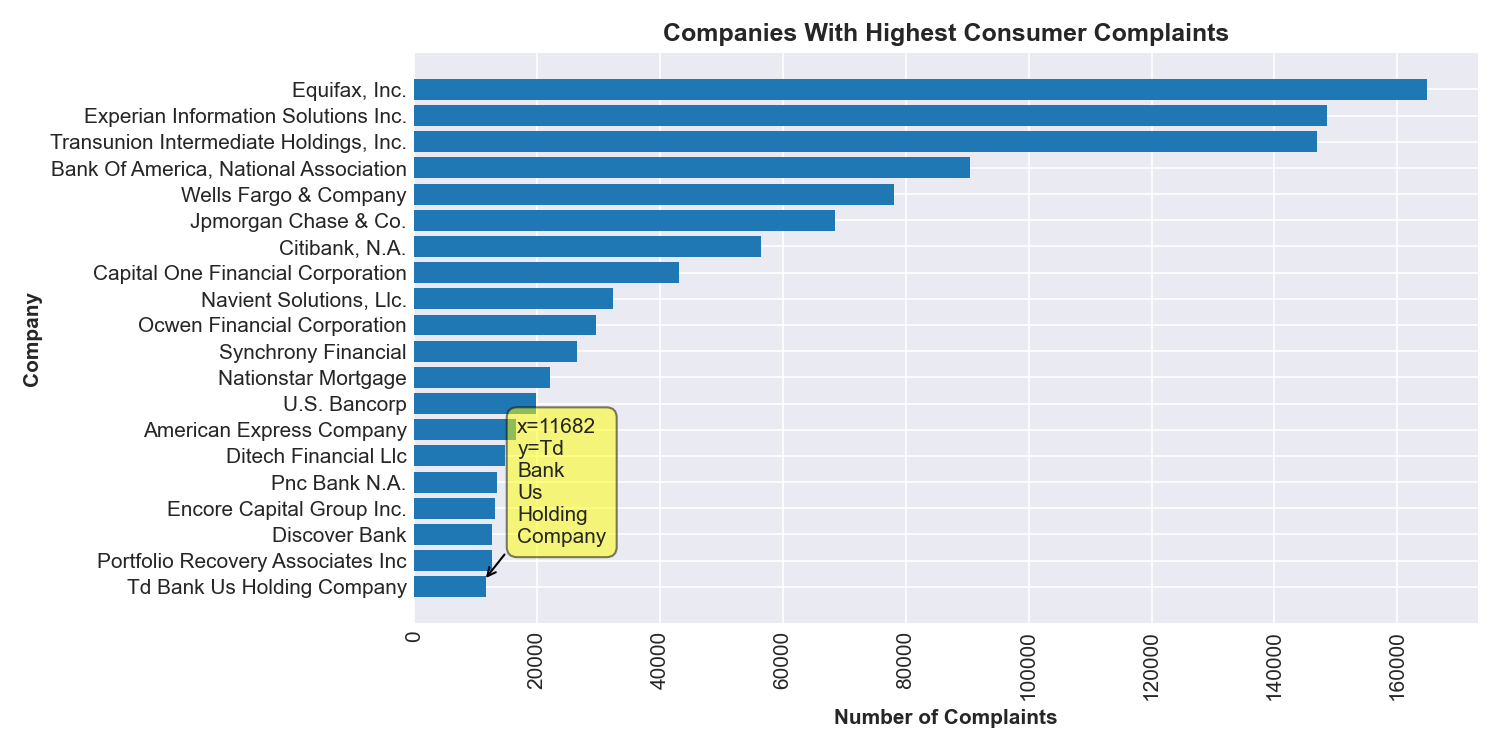

<ipython-input-62-0cb3104a4f28>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['company'] = [x.title() for x in counts['company']]


In [62]:
plt.figure()

rcParams.update({'figure.autolayout':True})
rcParams['figure.figsize'] = 10, 5

counts = company_counts_graph[0:20]
counts['company'] = [x.title() for x in counts['company']]

plt.barh(y = counts['company'], width = counts['count'])
plt.title('Companies With Highest Consumer Complaints', fontweight = 'bold')
plt.xlabel('Number of Complaints', fontweight = 'bold')
plt.ylabel('Company', fontweight = 'bold')
plt.xticks(rotation = 90)
plt.gca().invert_yaxis()
mplcursors.cursor(hover = True)

plt.show();

### Calculate Total Days and Average Complaints per Day

In [19]:
df = df.withColumn('date_received', df.date_received.cast(DateType()))

In [20]:
first_date = df.select('date_received').orderBy('date_received').take(1)
last_date = df.select('date_received').orderBy('date_received', ascending = False).take(1)

print('First Date:', first_date)
print('Last Date:', last_date)

First Date: [Row(date_received=datetime.date(2011, 12, 1))]
Last Date: [Row(date_received=datetime.date(2020, 5, 12))]


In [21]:
days = last_date[0]['date_received'] - first_date[0]['date_received']
print('Range of Days:', days)

Range of Days: 3085 days, 0:00:00


In [22]:
acd = df.count()/days.days
print('Average Complaints per Day:', acd)

Average Complaints per Day: 516.2145867098866


### Calculate Count of Complaints per Day

In [23]:
dates = df.select(df.date_received.alias('date'))
dates.sort('date').show()

+----------+
|      date|
+----------+
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
+----------+
only showing top 20 rows



In [24]:
cpd_pd = dates.groupBy('date').count().sort('date').toPandas()
cpd_pd

,date,count
0,2011-12-01,120
1,2011-12-02,138
2,2011-12-03,26
3,2011-12-04,22
4,2011-12-05,164
...,...,...
3080,2020-05-08,390
3081,2020-05-09,217
3082,2020-05-10,149
3083,2020-05-11,368


<IPython.core.display.Javascript object>


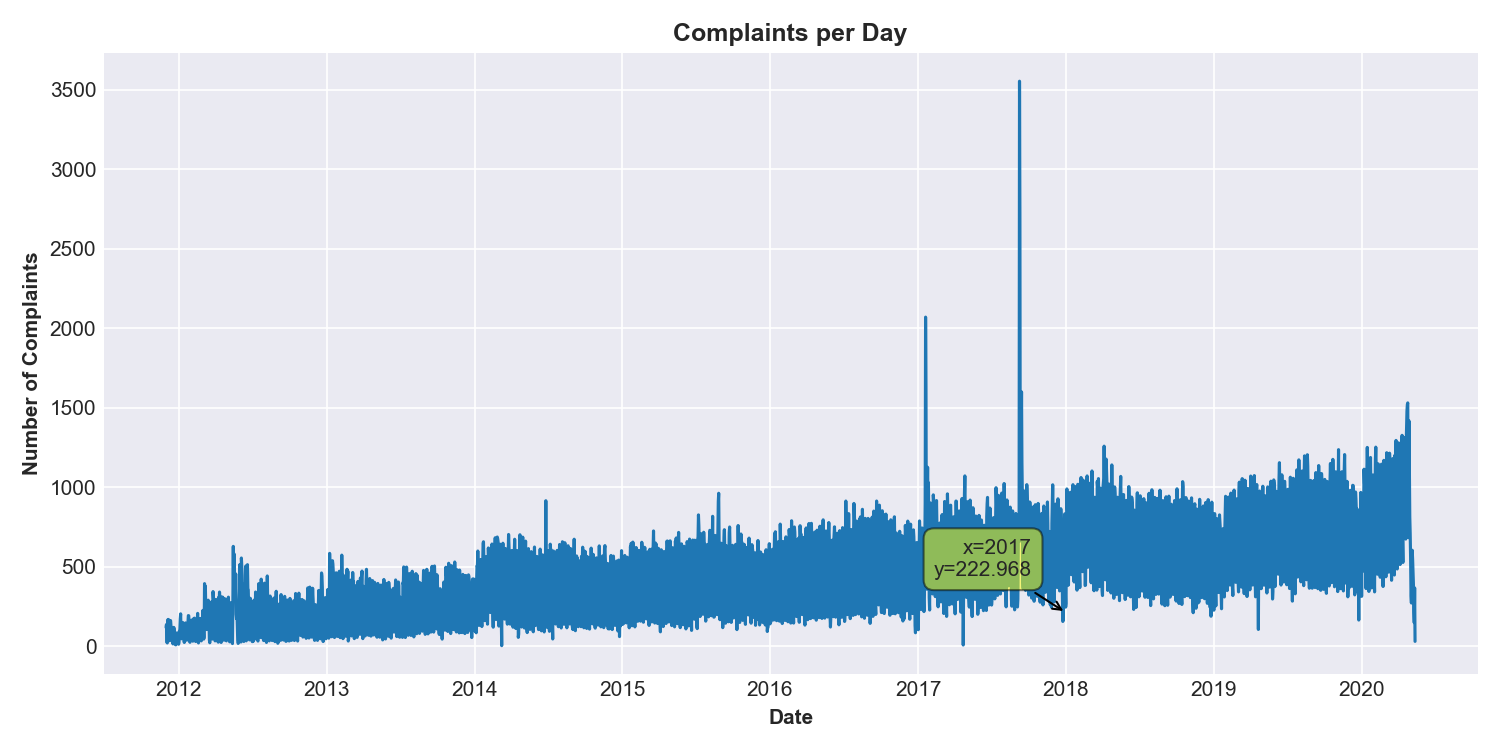

In [63]:
plt.figure()

rcParams['figure.figsize'] = 9, 5

plt.plot(cpd_pd['date'], cpd_pd['count'])
plt.title('Complaints per Day', fontweight = 'bold')
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Number of Complaints', fontweight = 'bold')

mplcursors.cursor(hover = True)
plt.show();

#### Days With High Complaint Count

In [26]:
dcd = dates.groupBy('date').count()
dcd.filter(dcd['count'] > 1500).orderBy('date').show()

+----------+-----+
|      date|count|
+----------+-----+
|2017-01-19| 2070|
|2017-01-20| 1633|
|2017-09-08| 3553|
|2017-09-09| 2709|
|2017-09-13| 1600|
|2020-04-23| 1521|
|2020-04-24| 1531|
+----------+-----+



#### Count Submission Method, Timely Response, and Consumer Dispute

In [27]:
submission_method = df.groupBy('submitted_via').count().sort('count', ascending = False)
submission_method.show()

+-------------+-------+
|submitted_via|  count|
+-------------+-------+
|          Web|1208808|
|     Referral| 193108|
|        Phone|  94676|
|  Postal mail|  74588|
|          Fax|  20920|
|        Email|    422|
+-------------+-------+



In [28]:
timely_response = df.groupBy('timely_response?').count().sort('count', ascending = False)
timely_response.show()

+----------------+-------+
|timely_response?|  count|
+----------------+-------+
|             Yes|1556049|
|              No|  36473|
+----------------+-------+



In [29]:
consumer_dispute = df.groupBy('consumer_disputed?').count().sort('count', ascending = False)
consumer_dispute.show()

+------------------+------+
|consumer_disputed?| count|
+------------------+------+
|              null|824045|
|                No|620099|
|               Yes|148378|
+------------------+------+



### Clean and Extract Consumer Complaint Narrative Column

In [30]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [31]:
data = df.filter((df['company'] == 'EQUIFAX, INC.') & (df['consumer_complaint_narrative'].isNull() == False))

In [32]:
data.select('consumer_complaint_narrative').show()

+----------------------------+
|consumer_complaint_narrative|
+----------------------------+
|        XXXX is reporting...|
|        XX/XX/XXXX XXXX X...|
|        In XX/XX/XXXX I b...|
|        I tried talking t...|
|        Under the new law...|
|        I sent this compa...|
|        After doing caref...|
|        Accounts added an...|
|        I have submitted ...|
|        I recently obtain...|
|        Hi, I sent out a ...|
|        The credit report...|
|        The information t...|
|        The collection ag...|
|        My old car was re...|
|        I have contacted ...|
|        XX/XX/18 called E...|
|        XXXX credit repor...|
|        Someone used info...|
|        I got a loan thro...|
+----------------------------+
only showing top 20 rows



In [33]:
data = data.withColumn('filtered', F.regexp_replace(F.col('consumer_complaint_narrative'), 'XXXX', ''))
data = data.withColumn('filtered', F.regexp_replace(F.col('filtered'), 'XX/', ''))
data = data.withColumn('filtered', F.regexp_replace(F.col('filtered'), '#', ''))

In [34]:
def lemmatize(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(x)

lemmatizeUDF = F.udf(lemmatize)

In [35]:
data = data.withColumn('lemmatize_words', lemmatizeUDF(data.filtered))
data.select('lemmatize_words').show()

+--------------------+
|     lemmatize_words|
+--------------------+
| is reporting inc...|
|         , NC  To...|
|In  I began my  s...|
|I tried talking t...|
|Under the new law...|
|I sent this compa...|
|After doing caref...|
|Accounts added an...|
|I have submitted ...|
|I recently obtain...|
|Hi, I sent out a ...|
|The credit report...|
|The information t...|
|The collection ag...|
|My old car was re...|
|I have contacted ...|
|18 called Equifax...|
| credit reporting...|
|Someone used info...|
|I got a loan thro...|
+--------------------+
only showing top 20 rows



In [36]:
tokenizer = Tokenizer(inputCol = 'lemmatize_words', outputCol = 'tokens')
data = tokenizer.transform(data)

In [37]:
stopwords_cleaner = StopWordsRemover(inputCol = 'tokens', outputCol = 'clean_words')
data = stopwords_cleaner.transform(data)

In [38]:
equifax_words = data.withColumn('exploded_text', F.explode(F.col('clean_words')))

In [39]:
equifax_words.columns

['date_received',
 'product',
 'sub-product',
 'issue',
 'sub-issue',
 'consumer_complaint_narrative',
 'company_public_response',
 'company',
 'state',
 'zip_code',
 'tags',
 'consumer_consent_provided?',
 'submitted_via',
 'date_sent_to_company',
 'company_response_to_consumer',
 'timely_response?',
 'consumer_disputed?',
 'complaint_id',
 'filtered',
 'lemmatize_words',
 'tokens',
 'clean_words',
 'exploded_text']

### Count Instances of Each Word

In [40]:
counts = equifax_words.groupby('exploded_text').count()
count_pd = counts.toPandas()
count_pd

,exploded_text,count
0,still,11065
1,standards,459
2,requirement,284
3,...,5033
4,likelihood,15
...,...,...
61501,fcpda.,1
61502,buld,1
61503,endorsee,1
61504,burieas,1


In [41]:
{count_pd.loc[i, 'exploded_text']:count_pd.loc[i, 'count'] for i in range(count_pd.shape[0])}

{'still': 11065,
 'standards': 459,
 'requirement': 284,
 '...': 5033,
 'likelihood': 15,
 'illegally.': 43,
 'online': 3580,
 'transmitted': 47,
 'transaction': 1460,
 'recognize': 614,
 'consumer.': 1405,
 'priority': 53,
 'current.': 244,
 'working,': 12,
 'filing': 1892,
 'c.': 81,
 'hope': 499,
 'equifax?': 67,
 'connected': 167,
 '8.5': 3,
 'courts.': 96,
 '3x': 22,
 'input': 84,
 'disconnected.': 74,
 'clinic.': 3,
 'responed': 7,
 'jewelry': 14,
 'harrassment.': 2,
 'involving': 99,
 'surprice!!!!!!': 1,
 'wife.': 46,
 'debunked': 1,
 'affairs,': 25,
 'timetable': 1,
 'deleterious': 7,
 'did.i': 2,
 'first-hand': 6,
 'enablement': 92,
 'escalated,': 5,
 'odviously': 1,
 'company?': 37,
 'inner': 2,
 'traveling': 24,
 'notification***': 3,
 'request-from': 1,
 'everyday': 65,
 'trail': 36,
 'credit.this': 2,
 'randomly': 63,
 'interaction': 16,
 'barrier': 29,
 'incoming': 7,
 'turn,': 42,
 'harder': 33,
 'anymore,': 16,
 'wtih': 4,
 'way!': 10,
 '(5)(a)': 2,
 'badily': 3,
 'fal

### Calculate TF-IDF For Each Term

In [42]:
company_counts = df.groupBy('company').count()
company_counts = company_counts.filter(company_counts['count']>1000).sort('count', ascending=False).toPandas()
companies = list(company_counts[0:20]['company'])
companies

['EQUIFAX, INC.',
 'Experian Information Solutions Inc.',
 'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
 'BANK OF AMERICA, NATIONAL ASSOCIATION',
 'WELLS FARGO & COMPANY',
 'JPMORGAN CHASE & CO.',
 'CITIBANK, N.A.',
 'CAPITAL ONE FINANCIAL CORPORATION',
 'Navient Solutions, LLC.',
 'Ocwen Financial Corporation',
 'SYNCHRONY FINANCIAL',
 'NATIONSTAR MORTGAGE',
 'U.S. BANCORP',
 'AMERICAN EXPRESS COMPANY',
 'Ditech Financial LLC',
 'PNC Bank N.A.',
 'ENCORE CAPITAL GROUP INC.',
 'DISCOVER BANK',
 'PORTFOLIO RECOVERY ASSOCIATES INC',
 'TD BANK US HOLDING COMPANY']

In [43]:
tokenizer = Tokenizer(inputCol = 'lemmatize_words', outputCol = 'tokens')

stopwords_cleaner = StopWordsRemover(inputCol = 'tokens', outputCol = 'clean_words')

pipeline = Pipeline().setStages([tokenizer, stopwords_cleaner])

In [44]:
company_complaint_count = {company: {} for company in companies}

for company in companies:
    print(company)
    
    company_df = df.filter((df['company'] == company) & (df['consumer_complaint_narrative'].isNull() == False))
    data = company_df.select('consumer_complaint_narrative')
    
    clean_data = data.withColumn('filtered', F.regexp_replace(F.col('consumer_complaint_narrative'), 'XXXX', ''))
    clean_data = clean_data.withColumn('filtered', F.regexp_replace(F.col('filtered'), 'XX/', ''))
    clean_data = clean_data.withColumn('filtered', F.regexp_replace(F.col('filtered'), '#', ''))
    clean_data = clean_data.withColumn('lemmatize_words', lemmatizeUDF(clean_data.filtered))
    clean_data = pipeline.fit(clean_data).transform(clean_data)
    
    clean_data_exploded = clean_data.withColumn('exploded_text', F.explode(F.col('clean_words')))
    counts = clean_data_exploded.groupby('exploded_text').count().toPandas()
    counts_dict = {counts.loc[i, 'exploded_text']:counts.loc[i, 'count'] for i in range(counts.shape[0])}
    
    company_complaint_count[company] = counts_dict

EQUIFAX, INC.
Experian Information Solutions Inc.
TRANSUNION INTERMEDIATE HOLDINGS, INC.
BANK OF AMERICA, NATIONAL ASSOCIATION
WELLS FARGO & COMPANY
JPMORGAN CHASE & CO.
CITIBANK, N.A.
CAPITAL ONE FINANCIAL CORPORATION
Navient Solutions, LLC.
Ocwen Financial Corporation
SYNCHRONY FINANCIAL
NATIONSTAR MORTGAGE
U.S. BANCORP
AMERICAN EXPRESS COMPANY
Ditech Financial LLC
PNC Bank N.A.
ENCORE CAPITAL GROUP INC.
DISCOVER BANK
PORTFOLIO RECOVERY ASSOCIATES INC
TD BANK US HOLDING COMPANY


In [45]:
def term_freq(terms_dict):
    total_words = sum(terms_dict.values())
    freq_dict = {word: terms_dict[word]/total_words for word in terms_dict.keys()}
    return freq_dict

def idf(list_of_words):
    total_docs = len(list_of_words)
    words = set([w for w_dict in list_of_words for w in w_dict.keys()])
    idf_dict = {word: log(float(total_docs)/(1.0 + sum([1 for w_dict in list_of_words if word in w_dict.keys()]))) for word in words}
    return idf_dict

def tf_idf(list_of_words):
    words = set([w for w_dict in list_of_words for w in w_dict.keys()])
    tf_idf_dict = []
    idfs = idf(list_of_words)
    for w_dict in list_of_words:
        w_dict.update({word: 0 for word in words if word not in w_dict.keys()})
        tf = term_freq(w_dict)
        tf_idf_dict.append({word: tf[word]*idfs[word] for word in words})
    return tf_idf_dict

In [46]:
list_terms = [company_complaint_count[company] for company in companies]
tf_idf_company = tf_idf(list_terms)
tf_idf_company_dict = {c: tf_dict for c, tf_dict in zip(companies, tf_idf_company)}

In [47]:
eng_words = words.words()

for company in companies:
    print('\n', company)
    tf_idf_dict = tf_idf_company_dict[company]
    t100 = heapq.nlargest(100, tf_idf_dict, key = tf_idf_dict.get)
    t100 = {word: tf_idf_dict[word] for word in t100}
    t100 = [(k,v) for k, v in zip(t100.keys(), t100.values())]
    t100 = sorted(t100, key = lambda x: x[1], reverse = True)
    
    counter = 0
    for word, tfidf in t100:
        if counter < 10:
            if word in eng_words:
                counter += 1
                print(word, tfidf)


 EQUIFAX, INC.
reseller 0.0002867467415113939
certifiably 6.986943025474816e-05
certifiable 6.114128111580726e-05
reinsertion 5.839991115065575e-05
compliantly 5.3174549419823875e-05
elsewise 4.636620181229792e-05
derelict 3.936302964635367e-05
runner 3.8891927011651934e-05
suppression 3.6920797879974064e-05
hesitating 3.543378248633657e-05

 Experian Information Solutions Inc.
reseller 0.000304437805223282
certifiably 7.438668710382498e-05
certifiable 6.463499825001213e-05
compliantly 5.442739352246685e-05
reinsertion 5.0646283525573674e-05
elsewise 4.919568594581623e-05
runner 4.5700054023699115e-05
derelict 4.1924061035190364e-05
suppression 3.681503567606322e-05
hesitating 3.680183467241868e-05

 TRANSUNION INTERMEDIATE HOLDINGS, INC.
reseller 0.0003283696195574396
certifiably 9.060077599498228e-05
tu 8.618498812431333e-05
certifiable 7.97299412657458e-05
compliantly 6.831578213262279e-05
elsewise 6.521449799737605e-05
reinsertion 6.152629362778416e-05
irrefutably 5.34329101976072

In [48]:
for company in companies:
    tf_idf_dict = tf_idf_company_dict[company]
    n_words = len([v for v in tf_idf_dict.values() if v > 0])
    print(f"{company}'s Number of Words: {n_words}")

EQUIFAX, INC.'s Number of Words: 53284
Experian Information Solutions Inc.'s Number of Words: 50792
TRANSUNION INTERMEDIATE HOLDINGS, INC.'s Number of Words: 46423
BANK OF AMERICA, NATIONAL ASSOCIATION's Number of Words: 45901
WELLS FARGO & COMPANY's Number of Words: 48029
JPMORGAN CHASE & CO.'s Number of Words: 44971
CITIBANK, N.A.'s Number of Words: 40710
CAPITAL ONE FINANCIAL CORPORATION's Number of Words: 31885
Navient Solutions, LLC.'s Number of Words: 31678
Ocwen Financial Corporation's Number of Words: 24935
SYNCHRONY FINANCIAL's Number of Words: 23750
NATIONSTAR MORTGAGE's Number of Words: 23736
U.S. BANCORP's Number of Words: 20648
AMERICAN EXPRESS COMPANY's Number of Words: 19653
Ditech Financial LLC's Number of Words: 15384
PNC Bank N.A.'s Number of Words: 13778
ENCORE CAPITAL GROUP INC.'s Number of Words: 9252
DISCOVER BANK's Number of Words: 15934
PORTFOLIO RECOVERY ASSOCIATES INC's Number of Words: 8871
TD BANK US HOLDING COMPANY's Number of Words: 12618


### Clean and Extract Consumer Complaint Narrative Column

In [49]:
tokenizer = Tokenizer(inputCol = 'lemmatize_words', outputCol = 'tokens')

stopwords_cleaner = StopWordsRemover(inputCol = 'tokens', outputCol = 'clean_words')

count_vectors = CountVectorizer(inputCol = 'clean_words', outputCol = 'features')

label_stringIdx = StringIndexer(inputCol = 'company', outputCol = 'label')

pipeline = Pipeline().setStages([tokenizer, stopwords_cleaner, count_vectors, label_stringIdx])

In [50]:
def lemmatize(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(x)

lemmatizeUDF = F.udf(lemmatize)

In [51]:
company_complaint_count = {company: {} for company in companies}

for company in companies:
    print(company)
    
    company_df = df.filter((df['company'] == company) & (df['consumer_complaint_narrative'].isNull() == False))
    
    clean_data = company_df.withColumn('filtered', F.regexp_replace(F.col('consumer_complaint_narrative'), 'XXXX', ''))
    clean_data = clean_data.withColumn('filtered', F.regexp_replace(F.col('filtered'), 'XX/', ''))
    clean_data = clean_data.withColumn('filtered', F.regexp_replace(F.col('filtered'), '#', ''))
    clean_data = clean_data.withColumn('lemmatize_words', lemmatizeUDF(clean_data.filtered))
    clean_data = pipeline.fit(clean_data).transform(clean_data)

EQUIFAX, INC.
Experian Information Solutions Inc.
TRANSUNION INTERMEDIATE HOLDINGS, INC.
BANK OF AMERICA, NATIONAL ASSOCIATION
WELLS FARGO & COMPANY
JPMORGAN CHASE & CO.
CITIBANK, N.A.
CAPITAL ONE FINANCIAL CORPORATION
Navient Solutions, LLC.
Ocwen Financial Corporation
SYNCHRONY FINANCIAL
NATIONSTAR MORTGAGE
U.S. BANCORP
AMERICAN EXPRESS COMPANY
Ditech Financial LLC
PNC Bank N.A.
ENCORE CAPITAL GROUP INC.
DISCOVER BANK
PORTFOLIO RECOVERY ASSOCIATES INC
TD BANK US HOLDING COMPANY


### Split and Predict Using GBTClassifier

In [52]:
(trainData, validData, testData) = clean_data.randomSplit([0.6, 0.2, 0.2], seed = 100)
print('Training Dataset Count:', trainData.count())
print('Validation Dataset Count:', validData.count())
print('Testing Dataset Count:', testData.count())

Training Dataset Count: 2078
Validation Dataset Count: 743
Testing Dataset Count: 691


In [53]:
gbtModel = GBTClassifier(labelCol = 'label', featuresCol = 'features', maxIter = 10)
gbtValPredictions = gbtModel.fit(trainData).transform(validData)

In [54]:
gbtValPredictions.select('company', 'label', 'rawPrediction', 'prediction', 'probability').show()

+--------------------+-----+--------------------+----------+--------------------+
|             company|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLD

In [55]:
gbtModelEval = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName = 'accuracy')
accuracy = gbtModelEval.evaluate(gbtValPredictions)
print('Accuracy: %g' % (accuracy))

Accuracy: 1


### Tune and Predict on Test Data

In [56]:
paramGrid = (ParamGridBuilder().addGrid(gbtModel.maxDepth, [2, 4, 6]).addGrid(gbtModel.maxBins, [20, 60]).addGrid(gbtModel.maxIter, [10, 20]).build())
cv = CrossValidator(estimator = gbtModel, estimatorParamMaps = paramGrid, evaluator = gbtModelEval, numFolds = 5)

In [57]:
cvModel = cv.fit(validData)
cvPredictions = cvModel.transform(testData)

In [58]:
cvPredictions.select('company', 'label', 'rawPrediction', 'prediction', 'probability').show()

+--------------------+-----+--------------------+----------+--------------------+
|             company|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLDIN...|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
|TD BANK US HOLD

In [59]:
accuracy = gbtModelEval.evaluate(cvPredictions)
print('Accuracy: %g' % (accuracy))

Accuracy: 1


### Conclusion

With high confidence and accuracy we can say our model is predicting the financial company tied to each complaint. This is a great start to futher data analysis that can be done in predicitng the product or issue regarding the complaint, to give use a better understanding of the product or issues that need to be fixed for the consumer. Another analysis can be done with predicting the state the complaint originiates from to analyze further of state demographics that are influencing the complaints, there might be something specific the company can improve in a state. Moreover, another analysis that I would like to do is see how the complaints reflect the stock market, if the market is doing well and the company valuation is high, there are more products the company might invest in, which in turn means more consumer profit as well as complaints, this can help analyze how new product roll-out is affecting the company and help improve supply chain of the company. It could also shed light on products that might need to be cut for the better of the company's future.